In [1]:
%matplotlib notebook
import os
import json
import argparse
import numpy as np
from plantcv import plantcv as pcv
import skimage
from scipy import ndimage as ndi

In [63]:
class options:
    def __init__(self):
        imgdir = os.path.expanduser("~/data/camelina/images/color_corrected_random_sample")
#         self.image = os.path.join(imgdir, "snapshot55352", "VIS_SV_0_z2500_h2_g0_e82_73778_0.png")
#         self.image = os.path.join(imgdir, "snapshot64325", "VIS_SV_0_z2500_h2_g0_e82_93416_0.png")
#         self.image = os.path.join(imgdir, "snapshot78092", "VIS_SV_0_z2500_h2_g0_e82_121298_0.png")
#         self.image = os.path.join(imgdir, "snapshot96694", "VIS_SV_0_z500_h2_g0_e82_157670_0.png")
#         self.image = os.path.join(imgdir, "snapshot111609", "VIS_SV_0_z500_h2_g0_e82_186374_0.png")
#         self.image = os.path.join(imgdir, "snapshot153320", "VIS_SV_0_z1_h1_g0_e82_266120_0.png")
        self.image = os.path.join(imgdir, "snapshot147152", "VIS_SV_0_z1_h1_g0_e82_256010_0.png")
        self.debug = "plot"
        self.writeimg = False
        self.result = "results.txt"
        self.outdir = "."
        self.bkg = "background_images.json"
        self.pdf = "naive_bayes_pdfs.txt"

In [64]:
# create options object for argument parsing
args = options()
# set debug
pcv.params.debug = args.debug

In [65]:
# read in a background image for each zoom level
config_file = open(args.bkg, 'r')
config = json.load(config_file)
config_file.close()
if "z2500" in args.image:
    bkg_image = os.path.expanduser(config["z2500"])
elif "z500" in args.image:
    bkg_image = os.path.expanduser(config["z500"])
elif "z1" in args.image:
    bkg_image = os.path.expanduser(config["z1"])
else:
    pcv.fatal_error("Image {0} has an unsupported zoom level.".format(args.image))

In [66]:
outfile = False
if args.writeimg:
    outfile = os.path.join(args.outdir, os.path.splitext(os.path.basename(args.image))[0])

<IPython.core.display.Javascript object>


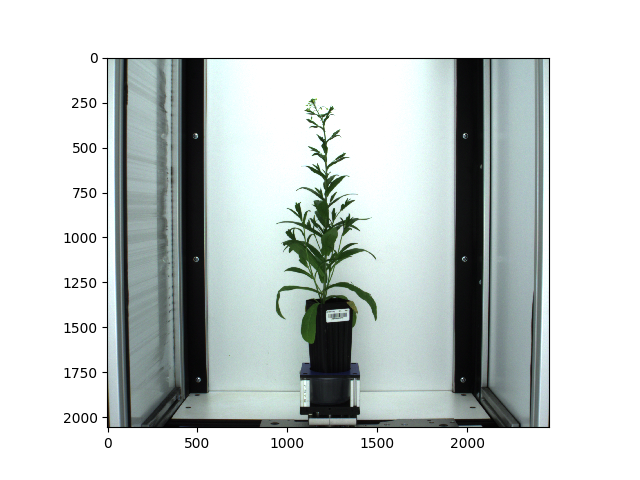

In [67]:
# read in image
img, path, filename = pcv.readimage(filename=args.image)

<IPython.core.display.Javascript object>


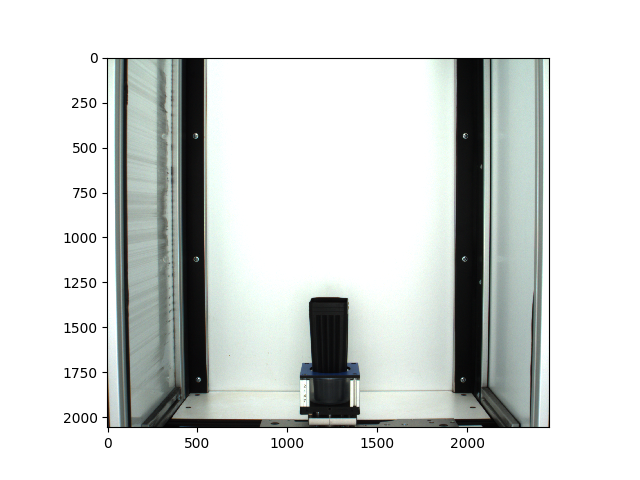

In [68]:
# read in a background image
bkg, bkg_path, bkg_filename = pcv.readimage(filename=bkg_image)

<IPython.core.display.Javascript object>


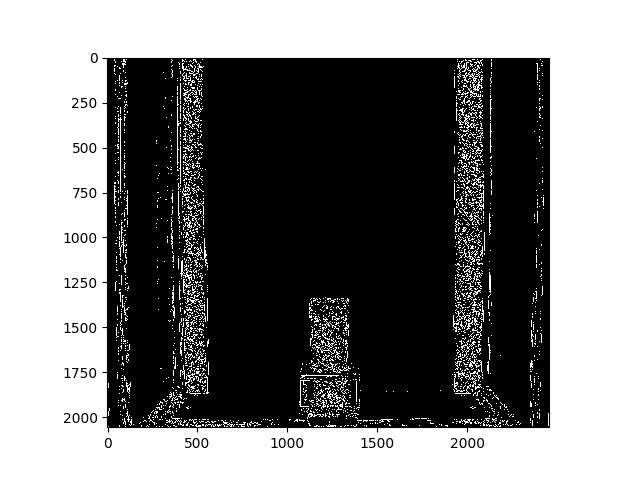

In [69]:
# Detect edges in the background image
bkg_sat = pcv.rgb2gray_hsv(rgb_img=bkg, channel="s")
bkg_edges = skimage.feature.canny(bkg_sat)
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=bkg_edges, filename=str(pcv.params.device) + '_background_edges.png')
elif args.debug == "plot":
    pcv.plot_image(img=bkg_edges, cmap="gray")

<IPython.core.display.Javascript object>


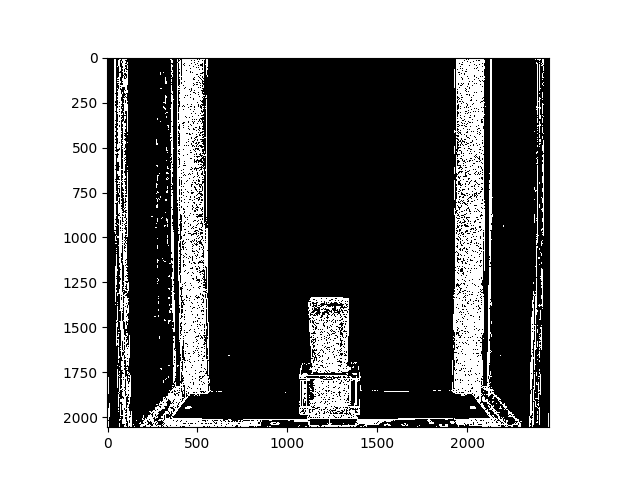

In [70]:
bkg_dil = pcv.dilate(gray_img=bkg_edges.astype(np.uint8), kernel=3, i=1)

<IPython.core.display.Javascript object>


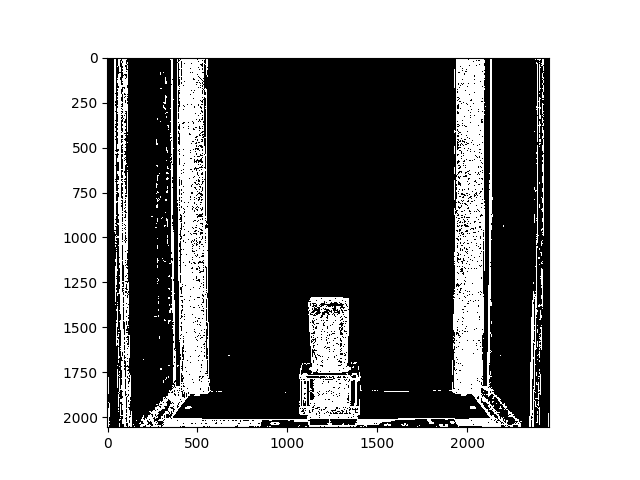

In [71]:
# Close contours
bkg_edges_closed = ndi.binary_closing(bkg_dil)
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=bkg_edges_closed, filename=str(pcv.params.device) + '_closed_background_edges.png')
elif args.debug == "plot":
    pcv.plot_image(img=bkg_edges_closed, cmap="gray")

<IPython.core.display.Javascript object>


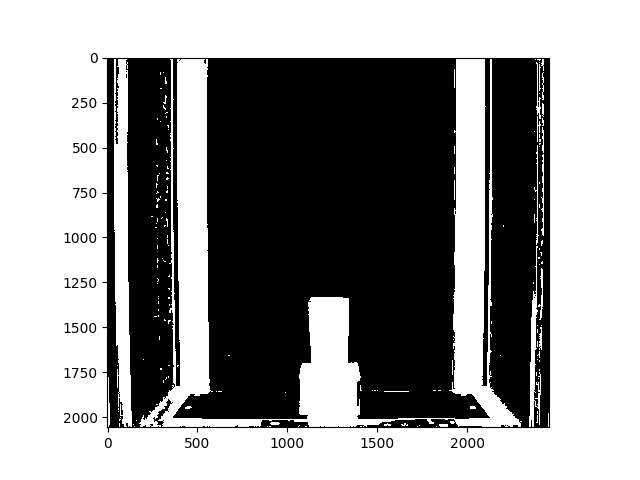

In [72]:
# Fill in closed contours in background
bkg_fill_contours = ndi.binary_fill_holes(bkg_edges_closed)
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=bkg_fill_contours, filename=str(pcv.params.device) + '_filled_background_edges.png')
elif args.debug == "plot":
    pcv.plot_image(img=bkg_fill_contours, cmap="gray")

<IPython.core.display.Javascript object>


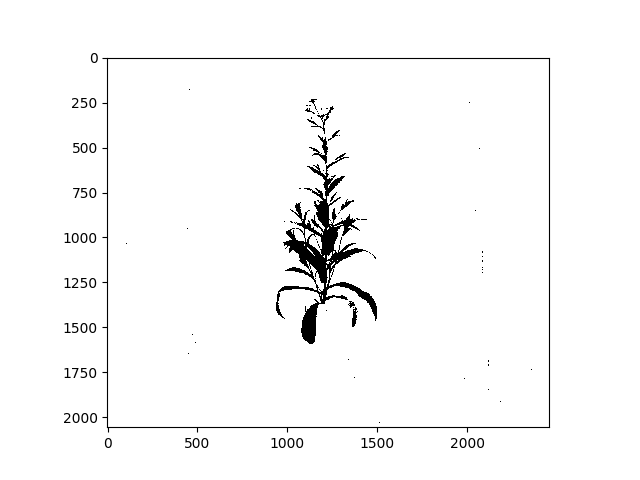

In [73]:
# naive bayes on image
masks = pcv.naive_bayes_classifier(rgb_img=img, pdf_file=args.pdf)

<IPython.core.display.Javascript object>


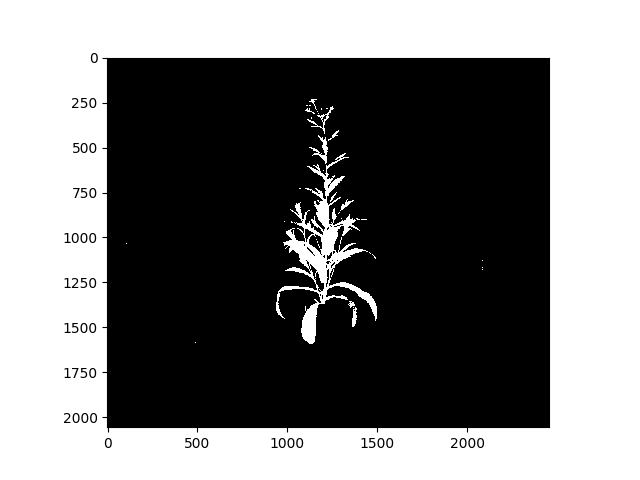

In [74]:
cleaned = pcv.fill(bin_img=masks["plant"], size=2)

<IPython.core.display.Javascript object>


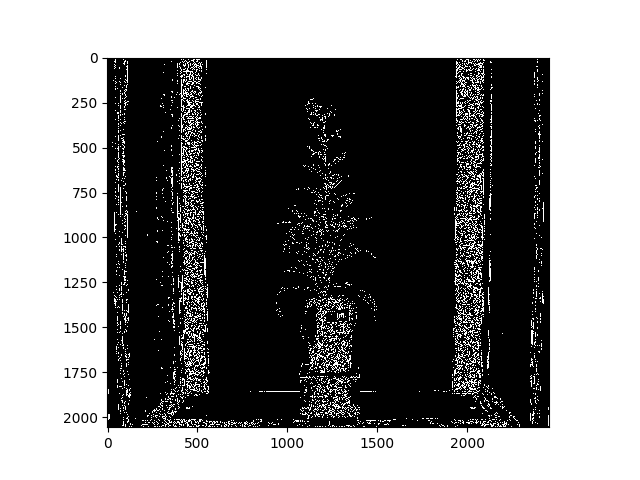

In [75]:
sat = pcv.rgb2gray_hsv(rgb_img=img, channel="s")
edges = skimage.feature.canny(sat)
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=edges, filename=str(pcv.params.device) + '_plant_edges.png')
elif args.debug == "plot":
    pcv.plot_image(img=edges, cmap="gray")

<IPython.core.display.Javascript object>


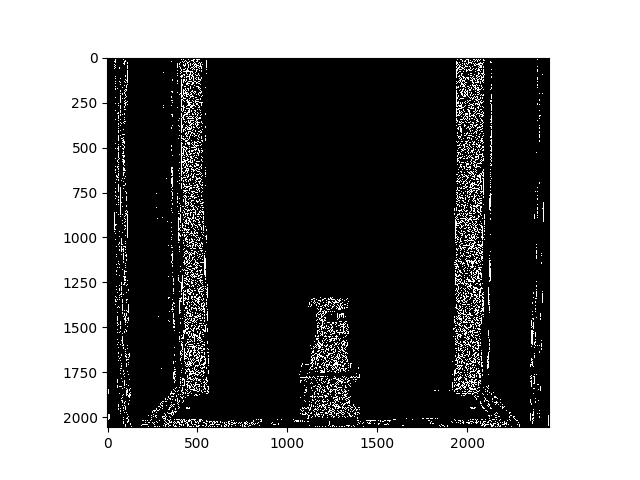

In [76]:
combined_bkg = pcv.logical_and(bin_img1=edges.astype(np.uint8) * 255, bin_img2=bkg_fill_contours.astype(np.uint8) * 255)

<IPython.core.display.Javascript object>


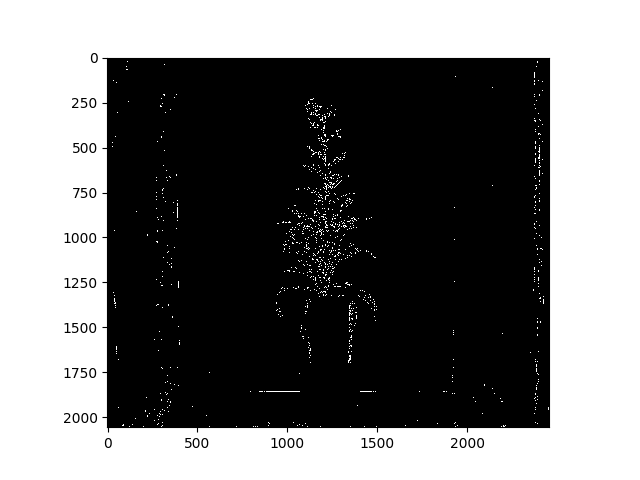

In [77]:
filtered = np.copy(edges)
filtered[np.where(combined_bkg == 255)] = False
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=filtered, filename=str(pcv.params.device) + '_filtered_edges.png')
elif args.debug == "plot":
    pcv.plot_image(img=filtered, cmap="gray")

<IPython.core.display.Javascript object>


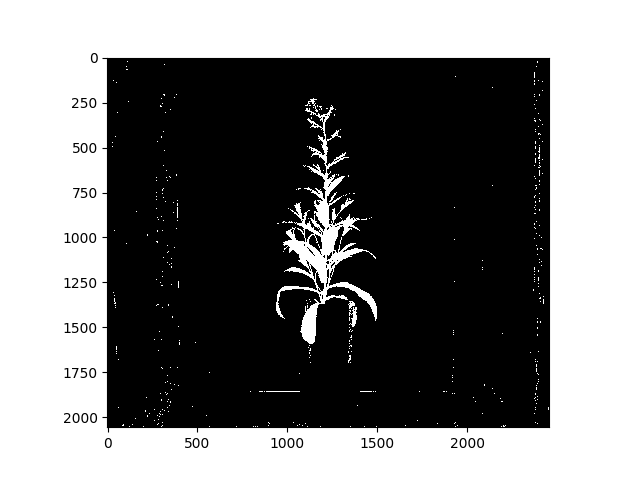

In [78]:
combined = pcv.logical_or(bin_img1=cleaned, bin_img2=filtered.astype(np.uint8)*255)

<IPython.core.display.Javascript object>


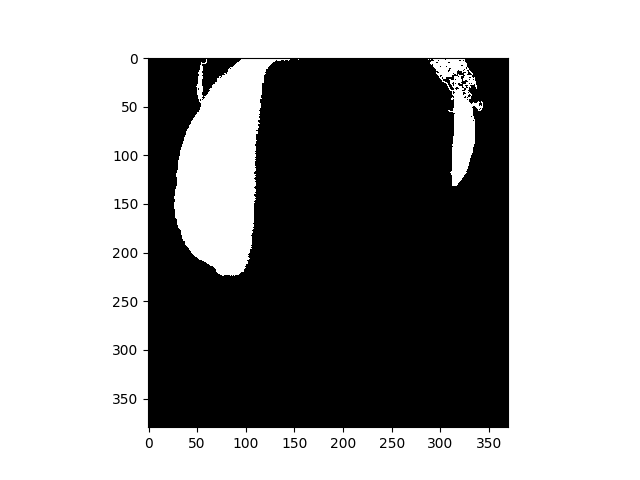

In [79]:
if "z2500" in args.image:
    pot_region = combined[450:1400, 850:1550]
    cleaned_pot = pcv.fill(bin_img=pot_region, size=100)
    combined[450:1400, 850:1550] = cleaned_pot
elif "z500" in args.image:
    pot_region = combined[740:1500, 1000:1450]
    cleaned_pot = pcv.fill(bin_img=pot_region, size=100)
    combined[740:1500, 1000:1450] = cleaned_pot
elif "z1" in args.image:
    pot_region = combined[1370:1750, 1050:1420]
    cleaned_pot = pcv.fill(bin_img=pot_region, size=100)
    combined[1370:1750, 1050:1420] = cleaned_pot
else:
    pcv.fatal_error("Image {0} has an unsupported zoom level.".format(args.image))

<IPython.core.display.Javascript object>


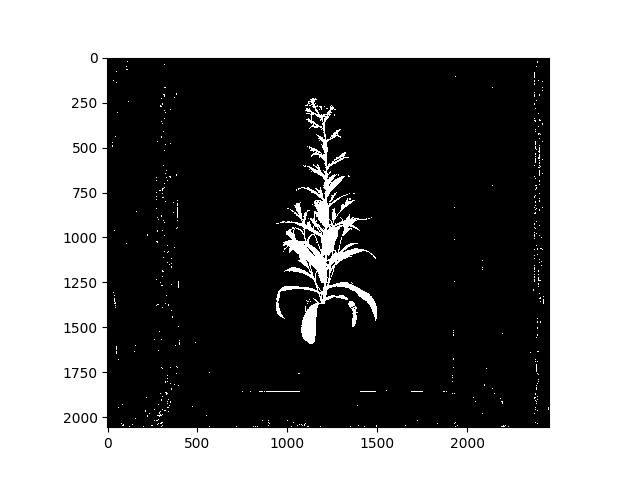

In [80]:
# Updated
closed_features = ndi.binary_closing(combined, structure=np.ones((3,3)))
pcv.params.device += 1
if args.debug == "print":
    pcv.print_image(img=closed_features, filename=str(pcv.params.device) + '_closed_features.png')
elif args.debug == "plot":
    pcv.plot_image(img=closed_features, cmap="gray")

<IPython.core.display.Javascript object>


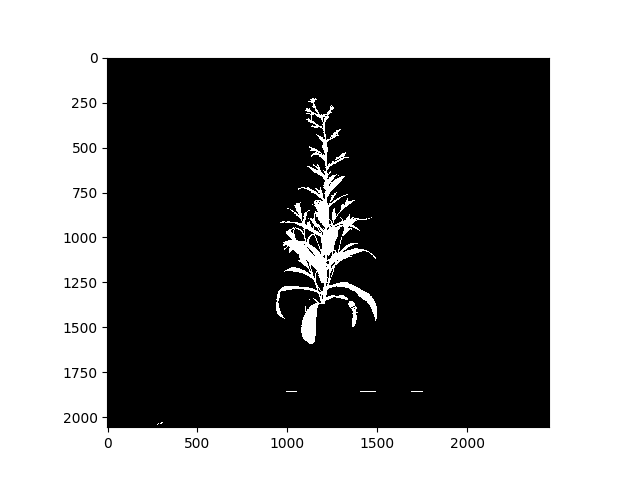

In [92]:
# image blurring using scipy median filter
blurred_img = pcv.median_blur(gray_img=closed_features.astype(np.uint8) * 255, ksize=(3, 1))
blurred_img = pcv.median_blur(gray_img=blurred_img, ksize=(1, 3))
cleaned2 = pcv.fill(bin_img=blurred_img, size=200)

<IPython.core.display.Javascript object>


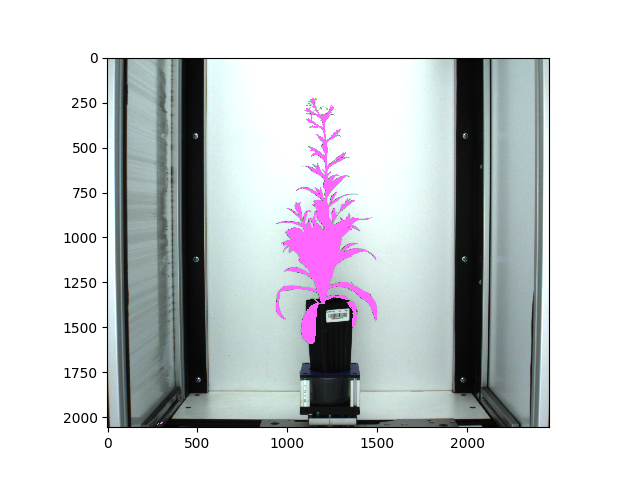

In [82]:
# Find contours using the cleaned mask
contours, contour_hierarchy = pcv.find_objects(img, np.copy(cleaned2.astype(np.uint8)*255))

<IPython.core.display.Javascript object>


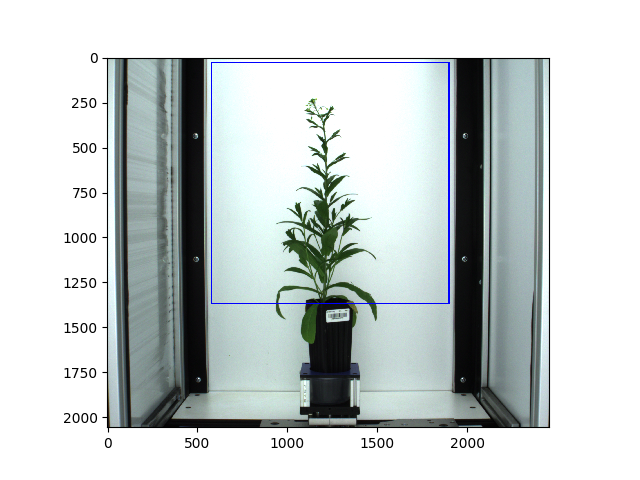

In [83]:
# Define region of interest for contour filtering
if "z2500" in args.image:
    x = 300
    y = 30
    h = 400
    w = 1850
elif "z500" in args.image:
    x = 500
    y = 30
    h = 710
    w = 1450
elif "z1" in args.image:
    x = 580
    y = 30
    h = 1340
    w = 1320
else:
    pcv.fatal_error("Image {0} has an unsupported zoom level.".format(args.image))
roi, roi_hierarchy = pcv.roi.rectangle(x=x, y=y, w=w, h=h, img=img)

<IPython.core.display.Javascript object>


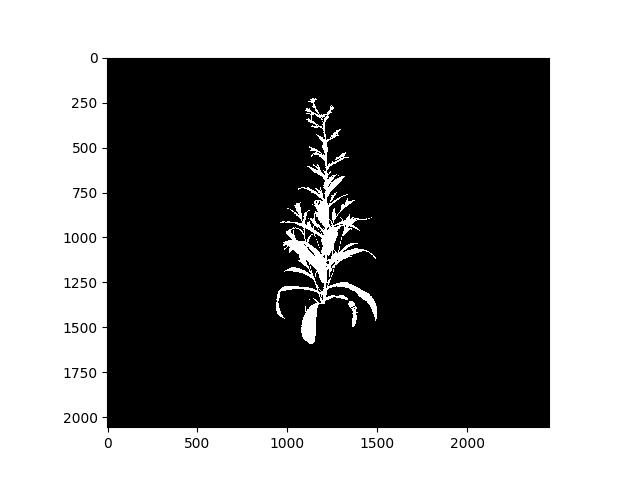

In [84]:
# Filter contours in the region of interest
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi, roi_hierarchy, contours, contour_hierarchy)

In [85]:
# Analyze only images with plants present
if len(roi_objects) > 0:
    print("Keep going")

Keep going


<IPython.core.display.Javascript object>


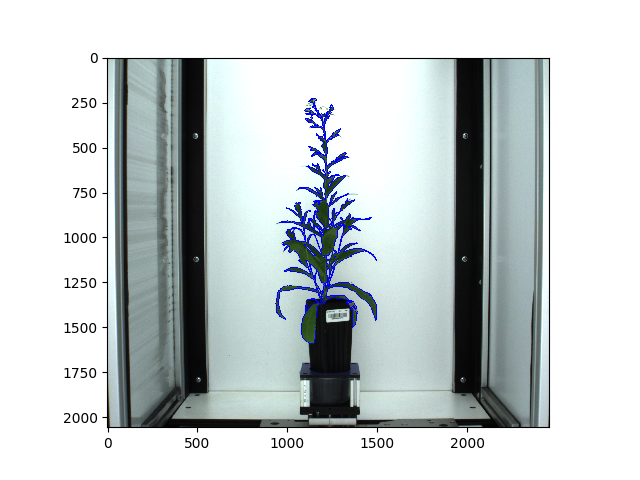

In [86]:
# Object combine kept objects
plant_contour, plant_mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy)

In [87]:
if args.writeimg:
    pcv.print_image(img=plant_mask, filename=outfile + "_mask.png")

<IPython.core.display.Javascript object>


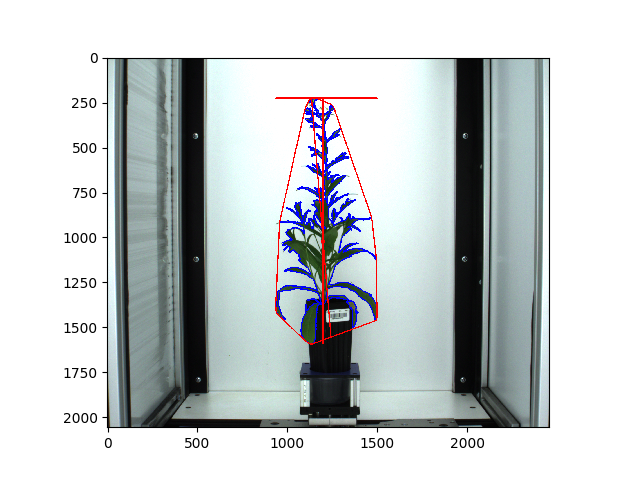

In [88]:
# Find shape properties, output shape image
shape_header, shape_data, shape_img = pcv.analyze_object(img=img, obj=plant_contour, mask=plant_mask, filename=outfile)

In [89]:
if "z2500" in args.image:
    line_position = 1600
elif "z500" in args.image:
    line_position = 1310
elif "z1" in args.image:
    line_position = 680
else:
    pcv.fatal_error("Image {0} has an unsupported zoom level.".format(args.image))

<IPython.core.display.Javascript object>


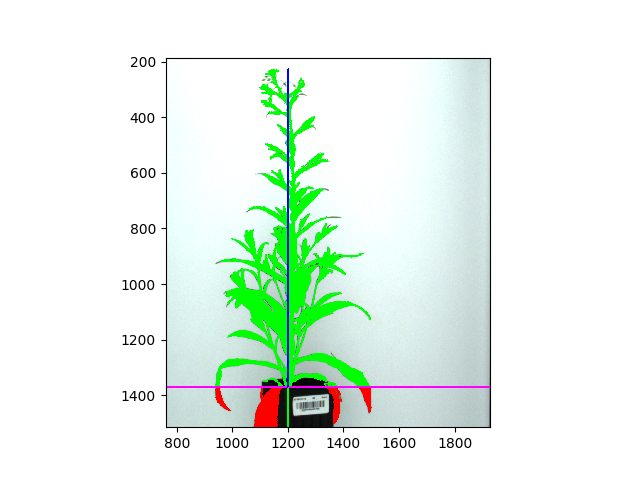

In [90]:
# Shape properties relative to user boundary line
boundary_header, boundary_data, boundary_img = pcv.analyze_bound_horizontal(img=img, obj=plant_contour,
                                                                            mask=plant_mask,
                                                                            line_position=line_position, 
                                                                            filename=outfile)


<IPython.core.display.Javascript object>


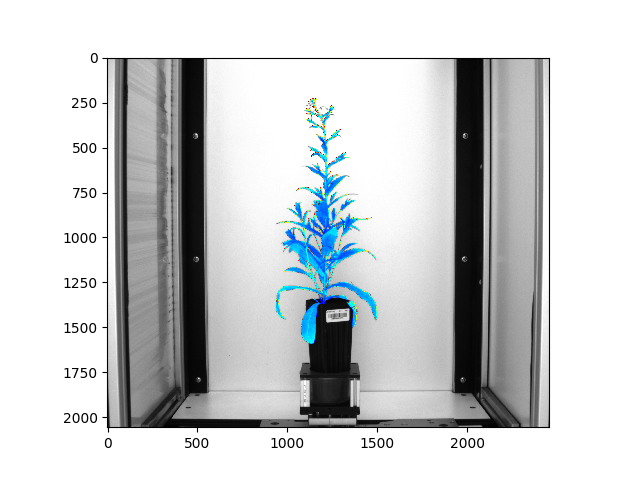

In [91]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images,
# output color analyzed images
color_header, color_data, color_img = pcv.analyze_color(rgb_img=img, mask=plant_mask, bins=256, hist_plot_type=None,
                                                        pseudo_channel="v", pseudo_bkg="img", filename=outfile)

In [32]:
# Output shape and color data
result = open(args.result, "a")
result.write('\t'.join(map(str, shape_header)) + "\n")
result.write('\t'.join(map(str, shape_data)) + "\n")
for row in shape_img:
    result.write('\t'.join(map(str, row)) + "\n")
result.write('\t'.join(map(str, color_header)) + "\n")
result.write('\t'.join(map(str, color_data)) + "\n")
result.write('\t'.join(map(str, boundary_header)) + "\n")
result.write('\t'.join(map(str, boundary_data)) + "\n")
result.write('\t'.join(map(str, boundary_img)) + "\n")
for row in color_img:
    result.write('\t'.join(map(str, row)) + "\n")
result.close()